# Word2Vec Embeddings+Classification

Here, we use Word2Vec to generate the embeddings of our recipes, starting by the embeddings of their respective ingredients. <br>
Then, we perform the classification task both in the single-label and multilabel case, by using standard machine learning classifiers i.e. logistic regression, SVM, random forest and MLP. 

???? non capisco

NOTE: THE LABELS CSV WAS ALREADY CLEANED FROM EMPTY RECIPES <br>
REMINDER: labels_path='./dataset/labels_stanza_10k.csv'

# Imports

In [7]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid

from gensim.models import word2vec

from tqdm import tqdm

from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
import keras

ImportError: cannot import name 'triu' from 'scipy.linalg' (/Users/irene/VSCodeProjects/HLT-Project/.venv/lib/python3.11/site-packages/scipy/linalg/__init__.py)

In [2]:
path='./dataset/ingredients_list_stanza_10k.csv'
df=pd.read_csv(path)

In [3]:
df[:2]

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,maple syrup,garlic,ginger,cayenne pepper,raisin,sage leave,vinegar,mustard,olive oil,clove,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,lime juice,grenadine syrup,cayenne pepper,juice,salt,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,garlic,cider vinegar,pepper flake,sugar,kosher salt,peppercorn,vinegar,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,lemon juice,tea,syrup,water,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,olive oil,cilantro leave,bell pepper,poblano pepper,plum tomato,lime,salt,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,olive oil,zucchini squash,chile,corn,clove garlic,butter,salt,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9996,baby basil,olive oil,confit,honey,oie gras,pear,worcestershire sauce,sugar,wine,cipollini onion,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9997,jalapeno pepper,cornbread,pork tenderloin,bean,nish,garlic,chili powder,cilantro leave,tomato,bell pepper,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9998,parmesan,olive oil,cheese,jack,lemon,artichoke,marjoram,russet,pepper,egg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


spiegare perche si fa + reference notebook in cui si trovano questi indici

In [10]:
empty=[ 211,  221,  300,  404, 1074, 1422, 1997, 2122, 2172, 2324, 2635, 2813,
       2831, 3380, 3457, 3858, 4058, 4327, 4379, 4642, 4727, 4736, 4870, 4899,
       4935, 5286, 5668, 5839, 6128, 6880, 7159, 7257, 7317, 7595, 7800, 7953,
       8192, 8276, 8350, 8820, 9199, 9221, 9616, 9663, 9705]

In [19]:
df.drop(empty, inplace=True)

# Word2Vec embeddings

We need to create the corpus as a list of sentences, where each sentence is the list of ingredients of each recipe.

In [24]:
corpus=[]
for i in df.index:
    list=[]
    for j in df.columns:
        val=df[j][i]
        if not (type(val) == float and np.isnan(val)):
            list.append(val)
    corpus.append(list)

In [27]:
len(corpus)

9955

In [29]:
embed_sz=100
window_sz=df.shape[1]
model = word2vec.Word2Vec(corpus, vector_size=embed_sz, window=window_sz, min_count=1, workers=4)

Given a word W in the corpus, we can check the most similar words to W 

In [30]:
#example of the 20 most similar words to a random word in the corpus
sims = model.wv.most_similar('milk', topn=20) 
sims

[('flour', 0.9922890663146973),
 ('egg', 0.9901657700538635),
 ('nutmeg', 0.988453209400177),
 ('elbow macaroni', 0.967231035232544),
 ('butter', 0.9617917537689209),
 ('tartar', 0.9551194310188293),
 ('yeast', 0.9515825510025024),
 ('ground ginger', 0.9436478614807129),
 ('pumpkin', 0.9429942965507507),
 ('cooking spray', 0.9410366415977478),
 ('crepe', 0.9405088424682617),
 ('buttermilk', 0.9402158856391907),
 ('cake flour', 0.9391579031944275),
 ('egg yolk', 0.9391164183616638),
 ('buckwheat flour', 0.9376630783081055),
 ('gruyere', 0.9374328255653381),
 ('pancake', 0.9358493685722351),
 ('yolk', 0.9353528618812561),
 ('blossom honey', 0.9321531057357788),
 ('confectioner', 0.9314513802528381)]

Let's do a 2D visualization of 100 ingredients via TSNE.

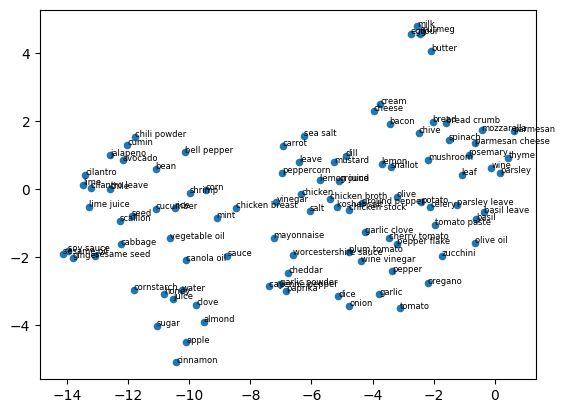

In [31]:
labels = []
count = 0
max_count = 100
X = np.zeros(shape=(max_count,embed_sz))

for term in model.wv.index_to_key:
    X[count] = model.wv[term]
    labels.append(term)
    count+= 1
    if count >= max_count: break

# It is recommended to use PCA first to reduce to ~50 dimensions
pca = PCA(n_components=50)
X_50 = pca.fit_transform(X)

# Using TSNE to further reduce to 2 dimensions
model_tsne = TSNE(n_components=2, random_state=0)
Y = model_tsne.fit_transform(X_50)

# Show the scatter plot
plt.scatter(Y[:,0], Y[:,1], 20)

# Add labels
for label, x, y in zip(labels, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy = (x,y), xytext = (0, 0), textcoords = 'offset points', size = 6)

plt.show()

Finally, we create the matrix where each row is the embedding of a recipe, each given by the midpoint in the space of its ingredients' embeddings.

In [32]:
recipe_embeddings=np.zeros((df.shape[0],embed_sz))

for i,list in enumerate(corpus):
    vec=np.zeros(embed_sz)
    for word in list:
        vec=vec+model.wv[word]
    vec=vec/float(len(list))
    recipe_embeddings[i,:]=vec   

In [36]:
np.savetxt('./dataset/embeddings_stanza_10k.csv',recipe_embeddings,delimiter=',')

# Data splitting and scaling

In [46]:
X_path='./dataset/embeddings_stanza_10k.csv'
X=pd.read_csv(X_path,header=None)

In [47]:
X

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.165805,0.271445,-0.016576,-0.043731,0.107624,-1.054667,0.275543,1.230130,-0.515281,-0.313986,...,0.718538,0.527409,0.155526,0.285259,0.873711,0.426568,0.440875,-0.294836,0.206305,-0.098356
1,-0.069072,0.240473,-0.148410,-0.125541,0.117467,-0.927273,0.139672,1.295435,-0.455371,-0.184420,...,0.727303,0.365923,0.332608,0.144989,0.855101,0.168549,0.564705,-0.540648,0.327705,-0.019993
2,-0.314959,0.268411,-0.068274,-0.030529,0.152581,-1.187055,0.349530,1.497826,-0.539797,-0.294291,...,0.790993,0.488611,0.227603,0.259857,0.921852,0.367840,0.512201,-0.424338,0.237265,-0.021522
3,-0.141818,0.179356,-0.096211,-0.041968,-0.002948,-0.846039,0.190941,1.092289,-0.424565,-0.194537,...,0.619760,0.372330,0.246211,0.184368,0.605899,0.276458,0.475333,-0.278668,0.192310,-0.034175
4,-0.311654,0.318416,-0.082248,-0.046331,0.232441,-1.007788,0.300784,1.519991,-0.514502,-0.221147,...,0.715498,0.355136,0.298513,0.060673,1.005073,0.132799,0.487650,-0.720808,0.433562,0.018146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9950,-0.259383,0.333144,0.039721,-0.026771,0.216562,-1.040631,0.335411,1.305739,-0.545018,-0.336623,...,0.682492,0.503369,0.112788,0.225620,0.994832,0.359685,0.357934,-0.453013,0.298808,-0.088515
9951,-0.140777,0.201766,-0.015618,-0.030935,0.092093,-0.843578,0.219839,0.979854,-0.406590,-0.251822,...,0.574151,0.413723,0.122416,0.233582,0.688432,0.328874,0.344371,-0.236242,0.152058,-0.062653
9952,-0.240585,0.299141,-0.063217,-0.072370,0.262280,-0.956357,0.249254,1.400325,-0.464538,-0.219545,...,0.672251,0.351905,0.255121,0.084600,1.017030,0.129892,0.435700,-0.693794,0.397294,0.000424
9953,-0.361153,0.353267,0.179985,0.045222,0.249971,-1.051911,0.424282,1.120610,-0.549643,-0.419821,...,0.596870,0.612779,-0.082401,0.328936,0.981981,0.533601,0.144951,-0.245021,0.201264,-0.156344


In [117]:
labels_path='./dataset/labels_stanza_10k.csv'

In [139]:
y=pd.read_csv(labels_path)

In [140]:
y=y['Vegetarian']

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [142]:
scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

So far, we created our training and test set, with a split of 70%/30%, and stratified with respect to the label. We also used the standard scaler on the two sets.

# Classification on the Vegetarian label

In [129]:
def plot_cm(y_test,y_pred):
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

## Logistic Regression

In [143]:
# fitting the model
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)
LogisticRegression()
# predictions
y_pred = logreg.predict(X_test_scaled)
y_pred_train = logreg.predict(X_train_scaled)

c:\Users\Giamm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [144]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.78      0.75      1490
           1       0.76      0.72      0.74      1497

    accuracy                           0.75      2987
   macro avg       0.75      0.75      0.75      2987
weighted avg       0.75      0.75      0.75      2987



Confusion Matrix:
[[1157  333]
 [ 424 1073]]


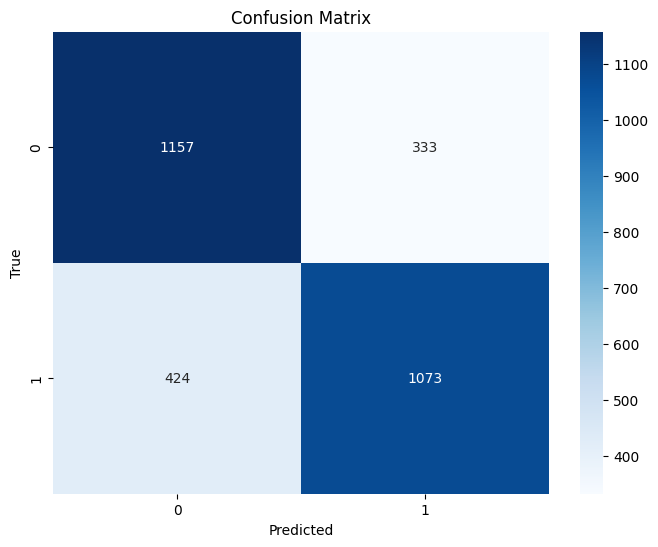

In [145]:
plot_cm(y_test,y_pred)

## SVM

In [146]:
param_grid = [
    {'C': [1000,3000,5000], 'gamma': [0.1,0.01,0.001], 'kernel': ['rbf']},
]

svc = SVC()
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'C': 3000, 'gamma': 0.1, 'kernel': 'rbf'}
Best cross-validation score: 0.81
              precision    recall  f1-score   support

           0       0.79      0.84      0.81      1490
           1       0.83      0.77      0.80      1497

    accuracy                           0.81      2987
   macro avg       0.81      0.81      0.81      2987
weighted avg       0.81      0.81      0.81      2987



Confusion Matrix:
[[1252  238]
 [ 338 1159]]


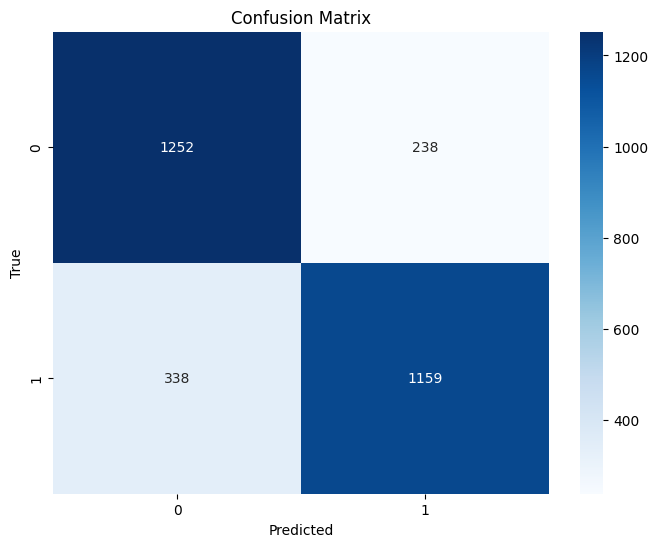

In [147]:
plot_cm(y_test,y_pred)

In [ ]:
SVM_best_config=grid_search.best_params_

## Random Forest

In [148]:
parameters = {'n_estimators': [50,100,200], 'max_depth':[None], 'min_samples_split':[2], 'min_samples_leaf': [1],'criterion' : ['gini','entropy'] }

grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid = parameters, cv=5, verbose=10, scoring='accuracy',n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.76
              precision    recall  f1-score   support

           0       0.75      0.81      0.78      1490
           1       0.80      0.73      0.76      1497

    accuracy                           0.77      2987
   macro avg       0.77      0.77      0.77      2987
weighted avg       0.77      0.77      0.77      2987



In [105]:
RF_best_config=grid_search.best_params_

Confusion Matrix:
[[1213  277]
 [ 407 1090]]


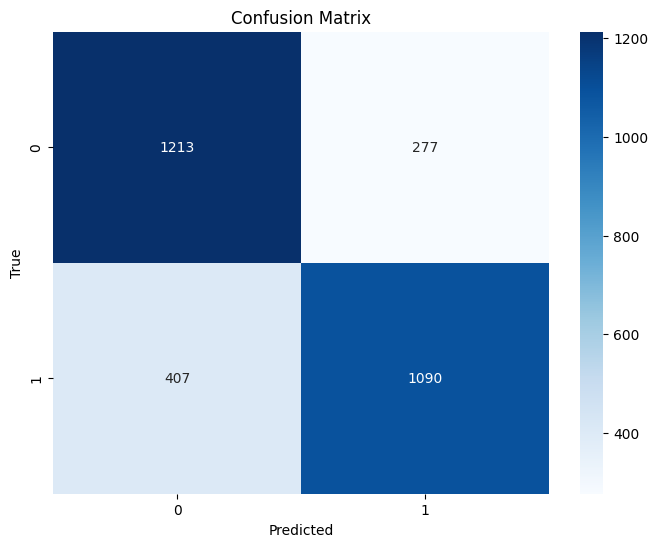

In [149]:
plot_cm(y_test,y_pred)

## MLP

In [114]:
param_grid={
    'optimizer': ['adam'],
    'first_layer_size': [ 32, 64],
    'second_layer_size': [16, 32],
    'reg_strength': [0.0001, 0.001, 0.01,],
    'lr':[0.001, 0.0001]
}

In [115]:
def kfold(X, y, k):
    for i in range(k+1):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=int(X.shape[0]/k), random_state=i)
        yield X_train, X_test, y_train, y_test

def grid_search_kfold(X,y, k, param_grid):
    best_score =0
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    for params in tqdm(ParameterGrid(param_grid)):
        #train on the k-1 folds

        model =Sequential([
                          Dense(params['first_layer_size'], activation='relu',
                                input_shape=(X.shape[1],), kernel_regularizer=l2(params['reg_strength'])),
                          Dense(params['second_layer_size'], activation='relu', kernel_regularizer=l2(params['reg_strength'])),
                          Dense(1, activation='sigmoid', kernel_regularizer=l2(params['reg_strength']))
                          ]
                        )
        early_stopping= EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')
        if params['optimizer']=='adam':
          opt= keras.optimizers.Adam(learning_rate=params['lr'])
        else:
          opt= keras.optimizers.SGD(learning_rate=params['lr'])
          
        model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
        model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, callbacks=[early_stopping], verbose=False)
        score = model.evaluate(X_test, y_test)
        print(score)
        if score[1] > best_score:
            best_score = score[1]
            best_params = params
    return best_params, best_score

In [123]:
best_params, best_score = grid_search_kfold(X_train_scaled, y_train, 3, param_grid)

  0%|          | 0/24 [00:00<?, ?it/s]

44/44 [==============================] - 0s 1ms/step - loss: 0.5216 - accuracy: 0.7496


  4%|▍         | 1/24 [00:06<02:30,  6.56s/it]

[0.5215699076652527, 0.7496412992477417]
44/44 [==============================] - 0s 1ms/step - loss: 0.5329 - accuracy: 0.7296


  8%|▊         | 2/24 [00:10<01:51,  5.06s/it]

[0.5328801870346069, 0.7295552492141724]
44/44 [==============================] - 0s 1ms/step - loss: 0.5475 - accuracy: 0.7425


 12%|█▎        | 3/24 [00:16<01:58,  5.65s/it]

[0.5475038886070251, 0.7424677014350891]
44/44 [==============================] - 0s 1ms/step - loss: 0.5511 - accuracy: 0.7382


 17%|█▋        | 4/24 [00:23<01:58,  5.92s/it]

[0.5511428713798523, 0.7381635308265686]
44/44 [==============================] - 0s 1ms/step - loss: 0.5776 - accuracy: 0.7288


 21%|██        | 5/24 [00:29<01:53,  5.96s/it]

[0.5775538086891174, 0.7288378477096558]
44/44 [==============================] - 0s 1ms/step - loss: 0.5893 - accuracy: 0.7138


 25%|██▌       | 6/24 [00:35<01:51,  6.18s/it]

[0.5892943143844604, 0.7137733101844788]
44/44 [==============================] - 0s 1ms/step - loss: 0.5495 - accuracy: 0.7152


 29%|██▉       | 7/24 [00:42<01:45,  6.22s/it]

[0.549541711807251, 0.7152080535888672]
44/44 [==============================] - 0s 1ms/step - loss: 0.5457 - accuracy: 0.7281


 33%|███▎      | 8/24 [00:48<01:39,  6.22s/it]

[0.5456740856170654, 0.7281205058097839]
44/44 [==============================] - 0s 1ms/step - loss: 0.6094 - accuracy: 0.7116


 38%|███▊      | 9/24 [00:54<01:33,  6.26s/it]

[0.6093879342079163, 0.7116212248802185]
44/44 [==============================] - 0s 1ms/step - loss: 0.6104 - accuracy: 0.7181


 42%|████▏     | 10/24 [01:01<01:28,  6.32s/it]

[0.6104236245155334, 0.7180774807929993]
44/44 [==============================] - 0s 1ms/step - loss: 0.7604 - accuracy: 0.7116


 46%|████▌     | 11/24 [01:07<01:21,  6.26s/it]

[0.7604309916496277, 0.7116212248802185]
44/44 [==============================] - 0s 1ms/step - loss: 0.7296 - accuracy: 0.7131


 50%|█████     | 12/24 [01:13<01:14,  6.24s/it]

[0.7295556664466858, 0.7130559682846069]
44/44 [==============================] - 0s 1ms/step - loss: 0.5262 - accuracy: 0.7389


 54%|█████▍    | 13/24 [01:19<01:07,  6.12s/it]

[0.526227593421936, 0.7388809323310852]
44/44 [==============================] - 0s 1ms/step - loss: 0.5299 - accuracy: 0.7425


 58%|█████▊    | 14/24 [01:24<00:57,  5.73s/it]

[0.5298793315887451, 0.7424677014350891]
44/44 [==============================] - 0s 2ms/step - loss: 0.5713 - accuracy: 0.7202


 62%|██████▎   | 15/24 [01:30<00:53,  5.92s/it]

[0.571265697479248, 0.7202295660972595]
44/44 [==============================] - 0s 1ms/step - loss: 0.5612 - accuracy: 0.7288


 67%|██████▋   | 16/24 [01:37<00:48,  6.08s/it]

[0.5612115859985352, 0.7288378477096558]
44/44 [==============================] - 0s 1ms/step - loss: 0.5872 - accuracy: 0.7174


 71%|███████   | 17/24 [01:43<00:43,  6.25s/it]

[0.5871652364730835, 0.7173601388931274]
44/44 [==============================] - 0s 1ms/step - loss: 0.5772 - accuracy: 0.7217


 75%|███████▌  | 18/24 [01:49<00:37,  6.18s/it]

[0.5772143602371216, 0.7216642498970032]
44/44 [==============================] - 0s 1ms/step - loss: 0.5523 - accuracy: 0.7131


 79%|███████▉  | 19/24 [01:56<00:31,  6.25s/it]

[0.5522966384887695, 0.7130559682846069]
44/44 [==============================] - 0s 1ms/step - loss: 0.5512 - accuracy: 0.7166


 83%|████████▎ | 20/24 [02:02<00:25,  6.31s/it]

[0.5512472987174988, 0.7166427373886108]
44/44 [==============================] - 0s 1ms/step - loss: 0.6194 - accuracy: 0.7238


 88%|████████▊ | 21/24 [02:09<00:19,  6.37s/it]

[0.6194309592247009, 0.7238163352012634]
44/44 [==============================] - 0s 1ms/step - loss: 0.6286 - accuracy: 0.7274


 92%|█████████▏| 22/24 [02:15<00:12,  6.41s/it]

[0.6285751461982727, 0.7274031639099121]
44/44 [==============================] - 0s 1ms/step - loss: 0.8154 - accuracy: 0.7181


 96%|█████████▌| 23/24 [02:22<00:06,  6.51s/it]

[0.8154104948043823, 0.7180774807929993]
44/44 [==============================] - 0s 1ms/step - loss: 0.7394 - accuracy: 0.7174


100%|██████████| 24/24 [02:29<00:00,  6.22s/it]

[0.7393593192100525, 0.7173601388931274]


In [124]:
best_params

{'first_layer_size': 32,
 'lr': 0.001,
 'optimizer': 'adam',
 'reg_strength': 0.0001,
 'second_layer_size': 16}

In [125]:
nn = Sequential([
                            Dense(best_params['first_layer_size'], activation='sigmoid',
                                    input_shape=(X_train_scaled.shape[1],), kernel_regularizer=l2(best_params['reg_strength'])),
                            Dense(best_params['second_layer_size'], activation='sigmoid', kernel_regularizer=l2(best_params['reg_strength'])),
                            Dense(1, activation='sigmoid', kernel_regularizer=l2(best_params['reg_strength']))
                            ]
                            )
nn.compile(optimizer=Adam(learning_rate=best_params['lr']), loss='binary_crossentropy', metrics=['accuracy'])
early_stopping= EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')
nn.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs=50, callbacks=[early_stopping], verbose=False)

In [126]:
y_pred = nn.predict(X_test_scaled)
y_pred_train = nn.predict(X_train_scaled)
y_pred = (y_pred > 0.5).astype(int)
y_pred_train = y_pred_train > 0.5

print('accuracy:', accuracy_score(y_test, y_pred),'\n')
print(classification_report(y_test, y_pred))

218/218 [==============================] - 0s 1ms/step
accuracy: 0.7679946434549716 

              precision    recall  f1-score   support

           0       0.75      0.81      0.78      1490
           1       0.79      0.73      0.76      1497

    accuracy                           0.77      2987
   macro avg       0.77      0.77      0.77      2987
weighted avg       0.77      0.77      0.77      2987



Confusion Matrix:
[[1200  290]
 [ 403 1094]]


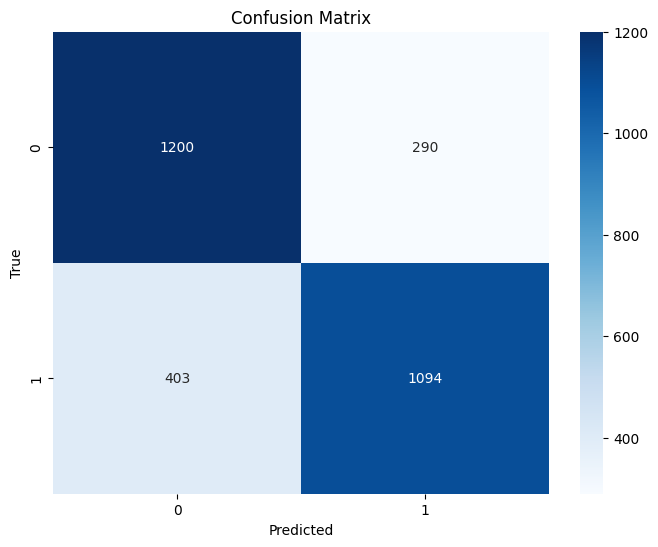

In [131]:
plot_cm(y_test,y_pred)

# Multi-label Classification

Unfortunately, methods such as Logistic Regression, SVM and Random Forest do not natively support multi-label classification. The MultiOutputClassifier from scikit-learn allows us to fit, given a classifier, as much classifiers as the number of labels. <br>
This means the classifiers will all share the same hyperparameters, but not the weights or any other parameter and structure dependent on the dataset and the fit procedure.

Thus, for the above-mentioned models, we will consider the hyperparameters of the configurations which performed best in the previous classification section.

In [132]:
y=pd.read_csv(labels_path)

In [80]:
y.sum(axis=0)

Vegetarian            4990
Dairy Free              68
Gluten Free           5389
Low Carb               663
Low Fat               1737
Low Sodium            1567
Dessert                485
Meat                  3836
Fish                  1529
Dairy                 1450
Vegetarian&Dessert    4990
Meat&Fish             4965
dtype: int64

We consider these six labels for multi-label classification.

In [133]:
y=y[['Dairy Free','Gluten Free','Low Carb','Low Fat','Low Sodium','Vegetarian']]

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [135]:
scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

## Logistic Regression

In [136]:
# fitting the model
logreg=MultiOutputClassifier(LogisticRegression(), n_jobs=-1)
logreg.fit(X_train_scaled, y_train)
# predictions
y_pred = logreg.predict(X_test_scaled)
y_pred_train = logreg.predict(X_train_scaled)

print('accuracy:', accuracy_score(y_test, y_pred),'\n')
print(classification_report(y_test, y_pred))

accuracy: 0.4506193505189153 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.74      0.82      0.78      1592
           2       0.00      0.00      0.00       178
           3       0.78      0.45      0.57       517
           4       0.75      0.45      0.56       465
           5       0.75      0.73      0.74      1457

   micro avg       0.75      0.66      0.70      4226
   macro avg       0.50      0.41      0.44      4226
weighted avg       0.71      0.66      0.68      4226
 samples avg       0.51      0.48      0.47      4226



c:\Users\Giamm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Giamm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Giamm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

## SVM

In [97]:
# fitting the model
svc=MultiOutputClassifier(SVC(**SVM_best_config), n_jobs=-1)
svc.fit(X_train_scaled, y_train)
# predictions
y_pred = svc.predict(X_test_scaled)
y_pred_train = svc.predict(X_train_scaled)

print('accuracy:', accuracy_score(y_test, y_pred),'\n')
print(classification_report(y_test, y_pred))

accuracy: 0.41613659189822566 

              precision    recall  f1-score   support

           0       0.08      0.06      0.07        17
           1       0.75      0.75      0.75      1592
           2       0.27      0.25      0.26       178
           3       0.58      0.52      0.55       517
           4       0.58      0.54      0.56       465
           5       0.73      0.74      0.74      1457

   micro avg       0.69      0.67      0.68      4226
   macro avg       0.50      0.48      0.49      4226
weighted avg       0.68      0.67      0.68      4226
 samples avg       0.48      0.47      0.45      4226



c:\Users\Giamm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Giamm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Random Forest

In [111]:
# fitting the model
rf=MultiOutputClassifier(RandomForestClassifier(**RF_best_config), n_jobs=-1)
rf.fit(X_train_scaled, y_train)
# predictions
y_pred = rf.predict(X_test_scaled)
y_pred_train = rf.predict(X_train_scaled)

print('accuracy:', accuracy_score(y_test, y_pred),'\n')
print(classification_report(y_test, y_pred))

accuracy: 0.48476732507532644 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.77      0.78      0.77      1592
           2       0.82      0.16      0.26       178
           3       0.77      0.51      0.61       517
           4       0.78      0.57      0.66       465
           5       0.77      0.72      0.75      1457

   micro avg       0.77      0.68      0.72      4226
   macro avg       0.65      0.46      0.51      4226
weighted avg       0.77      0.68      0.71      4226
 samples avg       0.50      0.47      0.46      4226



c:\Users\Giamm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Giamm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Giamm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

## MLP

# Final considerations

Unfortunately, Word2Vec suffers from major limitations, like the impossibility of generating a word embedding for an out-of-vocabulary word (without further training the model). <br>
Moreover, the way we created the recipe embeddings (by taking for each the midpoint of its ingredient embeddings) caused loss of information (compared to one-hot-encoding) and possibly poor representation: with this method, two recipes could be embedded very close by chance, even though they do not share any ingredient, or, on the other hand, they could be mapped far away from each other due to some ingredients being distant.<br>
Lastly, the classifiers scored decently in the single-label classification, but not as much for the multi-label task. <br> 
While this may mostly be caused by the very unbalanced dataset and the models being not designed for the task, it also suggests the need for more sofisticated methods to be deployed both for representation and classification.